In [ ]:
cd ~/qdpy-numpyro

In [ ]:
%run vorontsov_qdpy/mode_lister.py --nmin 5 --nmax 5 --lmin 60 --lmax 64
%run vorontsov_qdpy/precompute_ritzlavely.py
%run vorontsov_qdpy/generate_synthetic_eigvals.py --load_mults 1 --knot_num 5 --rth 0.97

In [ ]:
%run vorontsov_qdpy/save_reduced_problem.py
%run vorontsov_qdpy/save_reduced_problem_M.py

In [ ]:
%run vorontsov_qdpy/run_reduced_problem_model.py --warmup 10 --chain_num 5 --maxiter 10

In [ ]:
np.random.rand(5) @ (zfull[0][:, :, 0] @ np.random.rand(5))

In [ ]:
zfull = param_coeff @ true_params + fixed_part
zM = param_coeff_M @ true_params + fixed_part_M
bkm = param_coeff_bkm @ true_params + fixed_part_bkm
clp = get_clp(bkm)

mode_idx = -1
clp_200 = clp[mode_idx]

zfull_200 = zfull[mode_idx]
zM_200 = zM[mode_idx]
bkm_200 = bkm[mode_idx]
zfull_200_flat = jnp.reshape(zfull_200, (max_nbs*max_nbs*len_mmax), order='F')
zM_200_flat = jnp.reshape(zM_200, (max_nbs*max_nbs*len_mmax), order='F')
bkm_200_flat = jnp.reshape(bkm_200, (max_nbs*max_nbs*len_mmax), order='F')

sparse_idx_200 = sparse_idx[mode_idx]
sparseM_idx_200 = sparse_idx_M[mode_idx]

sparse_200_flat = jnp.reshape(sparse_idx_200, (max_nbs*max_nbs*len_mmax, 2), order='F')
sparseM_200_flat = jnp.reshape(sparseM_idx_200, (max_nbs*max_nbs*len_mmax, 2), order='F')


zf_dense = sparse.BCOO((zfull_200_flat, sparse_200_flat), shape=(dim_hyper, dim_hyper)).todense()
zMf_dense = sparse.BCOO((zM_200_flat, sparseM_200_flat), shape=(dim_hyper, dim_hyper)).todense()
bkm_dense = sparse.BCOO((bkm_200_flat, sparse_200_flat), shape=(dim_hyper, dim_hyper)).todense()
zf_diag = np.diag(zf_dense)
zMf_diag = np.diag(zMf_dense)

ev_200_V11 = np.sum(clp_200.conj() * (zM_200 * clp_200[:, NAX, :]).sum(axis=0), axis=0)

supmat = np.load("supmat_qdpt_200.npy").real
ev_200_eigh, evec_200 = jnp.linalg.eigh(supmat)
ev_200_eigh = eigval_sort_slice(ev_200_eigh/2./omega0_arr[-1], evec_200)[:401]

lmax_pjl = int(len_mmax//2)
dell = lmax_pjl - 200
ac1 = Pjl[-1] @ ev_200_V11/Pjl_norm[-1]
ac2 = Pjl[-1][:, dell:-dell] @ ev_200_eigh/Pjl_norm[-1]
print(ac1*GVARS.OM*1e6)
print(ac2*GVARS.OM*1e6)

In [ ]:
abs(ev_200_V11[dell:-dell] - ev_200_eigh).max()*1000/200

In [ ]:
def plot_fullmat(mat):
    vmax = abs(mat).max()
    fig = plt.figure()
    plt.imshow(mat, cmap='seismic', vmax=vmax/100000, vmin=-vmax/100000)
    return fig

fig = plot_fullmat(zMf_dense)
fig.show()

In [ ]:
plt.figure()
for i in range(5):
    plt.semilogy(abs(clp[0, 4, :]), label=i)
plt.legend()
plt.show()

### Comparing supermatrices with the ones constructed using qdPy

In [ ]:
supmat = np.load("supmat_qdpt_200.npy").real
matsize = supmat.shape[0]
qdpt_diag = np.diag(supmat)
plt.figure()
plt.plot(zf_diag[:matsize])
plt.plot(qdpt_diag, '--r')
plt.show()

plt.figure()
plt.semilogy(abs(zf_diag[:matsize] - qdpt_diag))
plt.show()

plt.figure()
plt.semilogy(abs(zf_dense[:matsize, :matsize].flatten() - supmat.flatten()))
plt.show()

matdiff = abs(supmat - zf_dense[:matsize, :matsize])
thresh = 1e-11
print(f"max diff = {matdiff.max()}")
print(f"count of diff > {thresh} = {(matdiff>thresh).sum()}")

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs = axs.flatten()
im1 = axs[0].imshow(zf_dense[:matsize, :matsize])
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(supmat)
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(zf_dense[:matsize, :matsize] - supmat)
plt.colorbar(im2, ax=axs[2])
fig.show()



## Testing out the compare_model function

In [ ]:
mult_idx = -1
z0 = param_coeff_M[mult_idx] @ true_params + fixed_part_M[mult_idx]
zfull = param_coeff[mult_idx] @ true_params + fixed_part[mult_idx]
bkm = param_coeff_bkm @ true_params + fixed_part_bkm

for midx in range(nmults):
    bkm = jidx_update(bkm, 
                      jidx[midx, :, :, :],
                      -1.0*bkm[midx]/dom_dell_jax[midx])
                         
clp = get_clp(bkm)[mult_idx]
bkm = bkm[mult_idx]
                        
omegaref = omega0_arr_jax[mult_idx]
ell0 = ell0_arr_jax[mult_idx]

z1 = zfull/2./omegaref - z0
_eigval0mult = get_eig_corr(clp, z0)*GVARS.OM*1e6
_eigval1mult = get_eig_corr(clp, z1)*GVARS.OM*1e6
_eigval_mult = _eigval0mult + _eigval1mult

Pjl_local = Pjl[mult_idx]

In [ ]:
plt.figure()
plt.plot(_eigval_mult[-10:], '--r')
plt.plot(Pjl_local[0, -10:], 'k')
plt.show()

plt.figure()
plt.plot(_eigval_mult[:10], '--r')
plt.plot(Pjl_local[0, :10], 'k')
plt.show()

### Explicit computation of eigenvalues

In [ ]:
def eigval_sort_slice(eigval, eigvec):
    eigbasis_sort = np.zeros(len(eigval), dtype=int)
    for i in range(len(eigval)):
        eigbasis_sort[i] = np.argmax(abs(eigvec[i]))
    return eigval[eigbasis_sort]

ell0 = 200
omegaref = omega0_arr[-1]
supmat = np.load(f"supmat_qdpt_{ell0}.npy").real


eigvals, eigvecs = np.linalg.eigh(supmat)
eigvals = eigval_sort_slice(eigvals, eigvecs)
eigvals = eigvals[:2*ell0+1]/2./omegaref*GVARS.OM*1e6

supmat2 = zf_dense[:matsize, :matsize]
eigvals2, eigvecs2 = np.linalg.eigh(supmat2)
eigvals2 = eigval_sort_slice(eigvals2, eigvecs2)
eigvals2 = eigvals2[:2*ell0+1]/2./omegaref*GVARS.OM*1e6

acoeffs = (Pjl[-1][:, :2*ell0+1] @ eigvals)/Pjl_norm[-1]
acoeffs2 = (Pjl[-1][:, :2*ell0+1] @ eigvals2)/Pjl_norm[-1]
print(acoeffs)
print(acoeffs2)

## TESTING OUT DPY_JAX

In [1]:
cd ~/qdpy-numpyro

/mnt/disk2/samarth/qdpy-numpyro


In [2]:
%run dpy_jax/mode_lister.py --nmin 0 --nmax 1 --lmin 100 --lmax 250
%run dpy_jax/precompute_ritzlavely.py
%run dpy_jax/generate_synthetic_eigvals.py --load_mults 1 --knot_num 5 --rth 0.97
%run dpy_jax/save_reduced_problem.py

MODE NOT FOUND : l = 100, n =  0
MODE NOT FOUND : l = 101, n =  0
MODE NOT FOUND : l = 102, n =  0
MODE NOT FOUND : l = 103, n =  0
MODE NOT FOUND : l = 104, n =  0
MODE NOT FOUND : l = 105, n =  0
MODE NOT FOUND : l = 106, n =  0
MODE NOT FOUND : l = 107, n =  0
MODE NOT FOUND : l = 108, n =  0
MODE NOT FOUND : l = 109, n =  0
MODE NOT FOUND : l = 110, n =  0
MODE NOT FOUND : l = 111, n =  0
MODE NOT FOUND : l = 112, n =  0
MODE NOT FOUND : l = 113, n =  0
MODE NOT FOUND : l = 114, n =  0
MODE NOT FOUND : l = 115, n =  0
MODE NOT FOUND : l = 116, n =  0
MODE NOT FOUND : l = 117, n =  0
MODE NOT FOUND : l = 118, n =  0
MODE NOT FOUND : l = 119, n =  0
MODE NOT FOUND : l = 120, n =  0
MODE NOT FOUND : l = 121, n =  0
MODE NOT FOUND : l = 122, n =  0
MODE NOT FOUND : l = 123, n =  0
MODE NOT FOUND : l = 124, n =  0
MODE NOT FOUND : l = 125, n =  0
MODE NOT FOUND : l = 126, n =  0
MODE NOT FOUND : l = 127, n =  0
MODE NOT FOUND : l = 128, n =  0
MODE NOT FOUND : l = 129, n =  0
MODE NOT F

Precomputing for s=5: 100%|██████████| 191/191 [00:01<00:00, 98.29it/s] 


JAX using: cpu


Loading eigenfunctions...: 100%|██████████| 191/191 [00:02<00:00, 75.70it/s]


JAX using: cpu


Precomputing for s=5: 100%|██████████| 191/191 [00:01<00:00, 106.90it/s]


/mnt/disk2/samarth/anaconda3/envs/jax-gpu/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 10000/10000 [14:58<00:00, 11.13it/s, 31 steps of size 2.08e-02. acc. prob=0.92]  
/mnt/disk2/samarth/anaconda3/envs/jax-gpu/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:254: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(


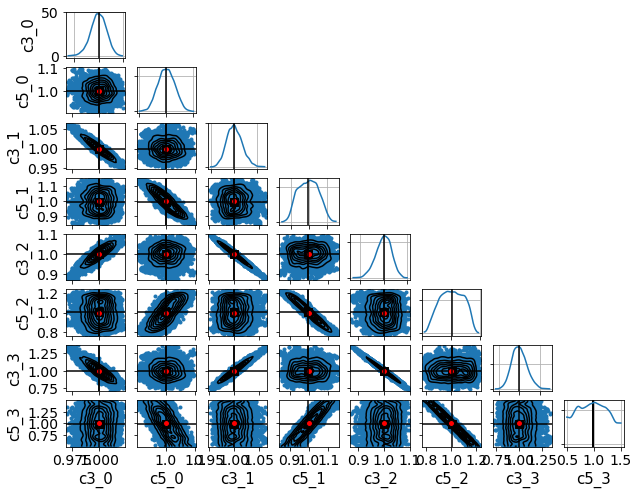

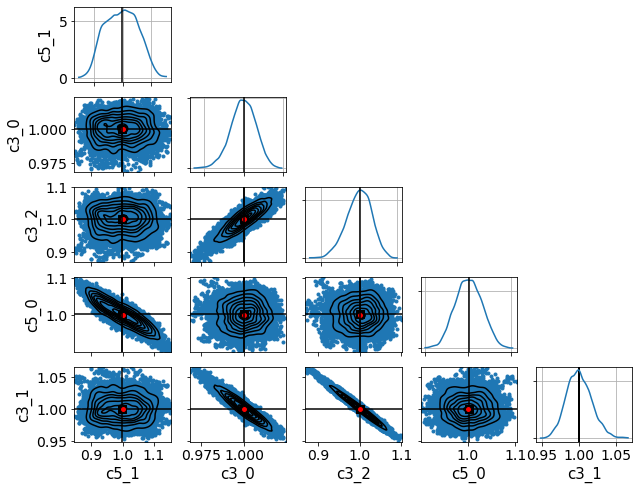

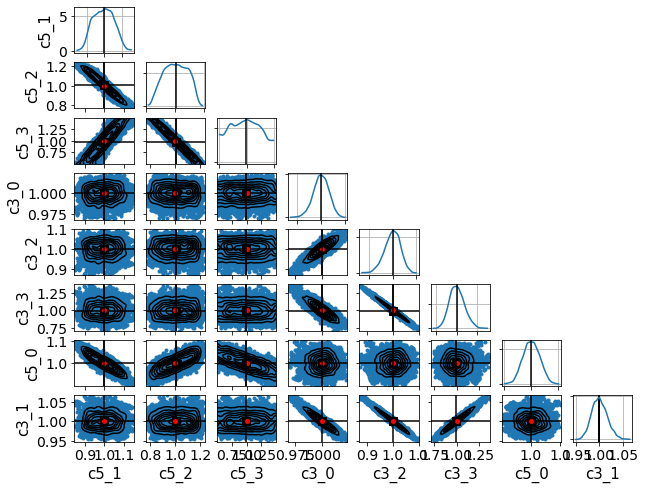

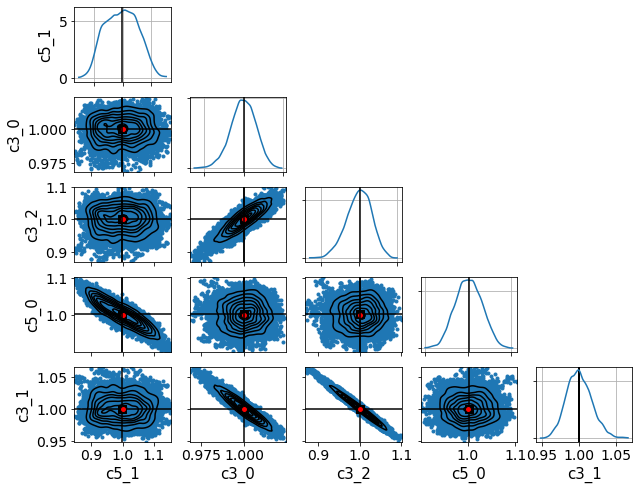

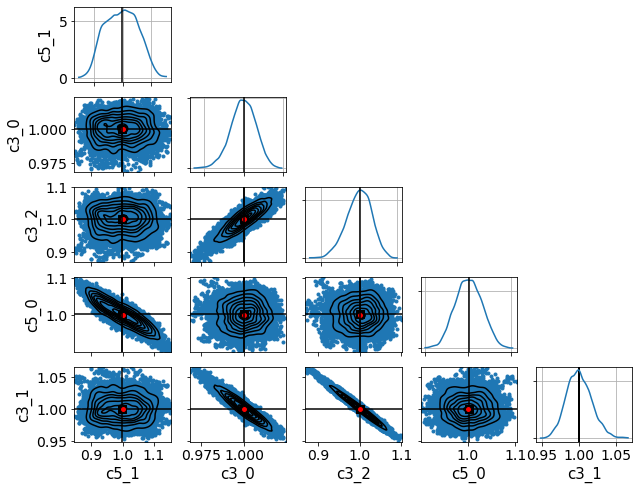

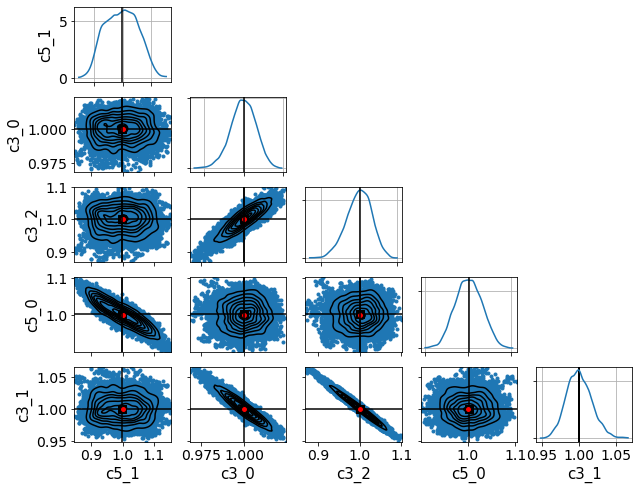

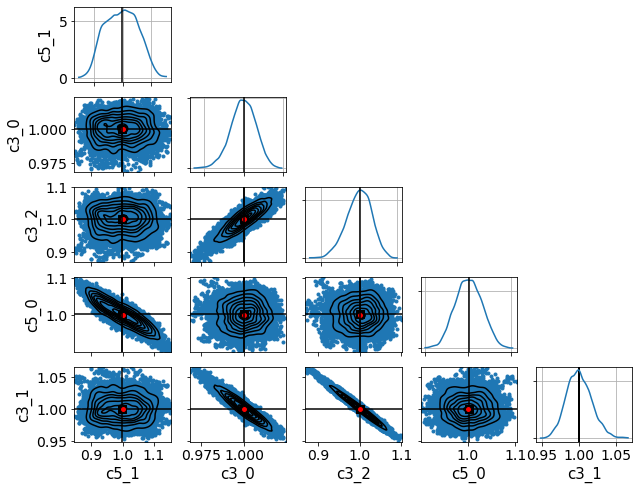

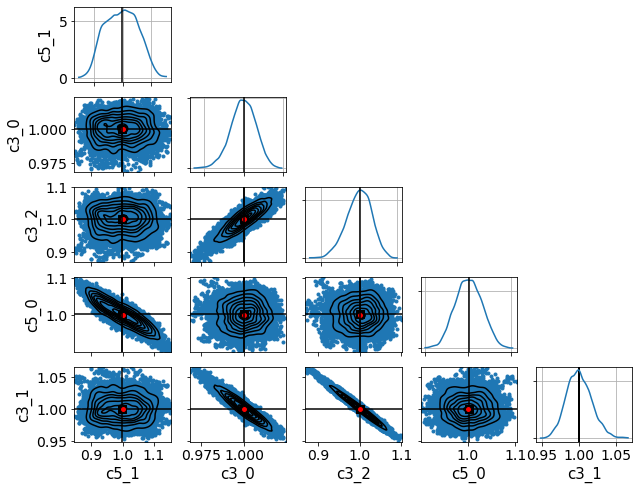

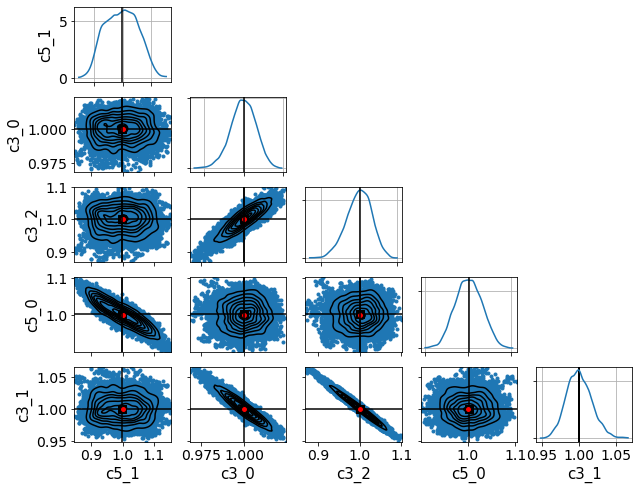

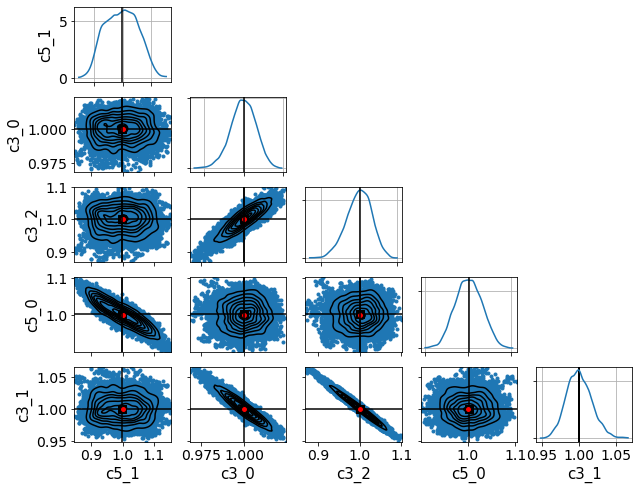

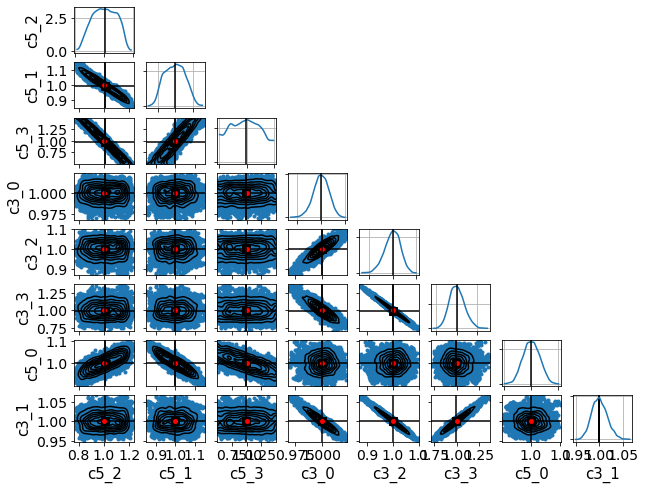

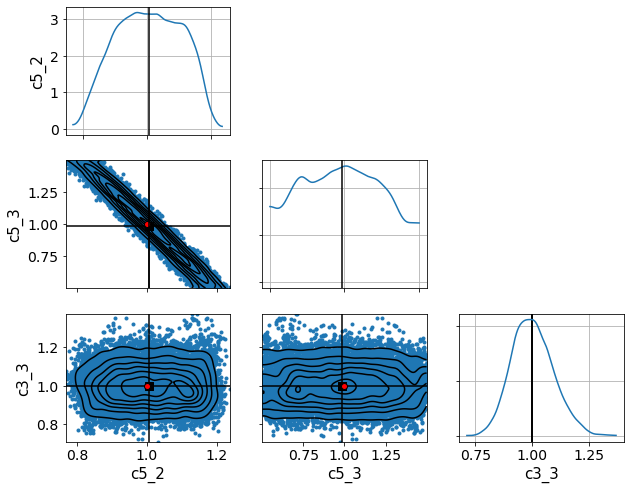

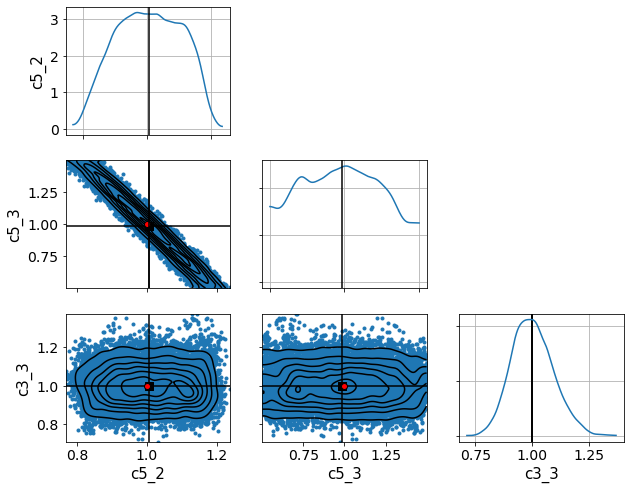

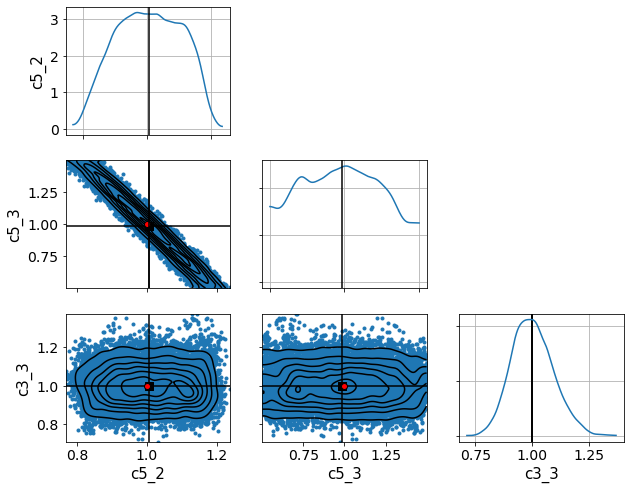

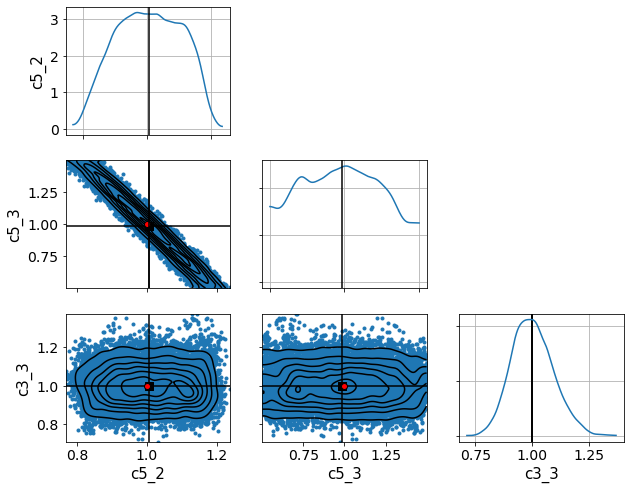

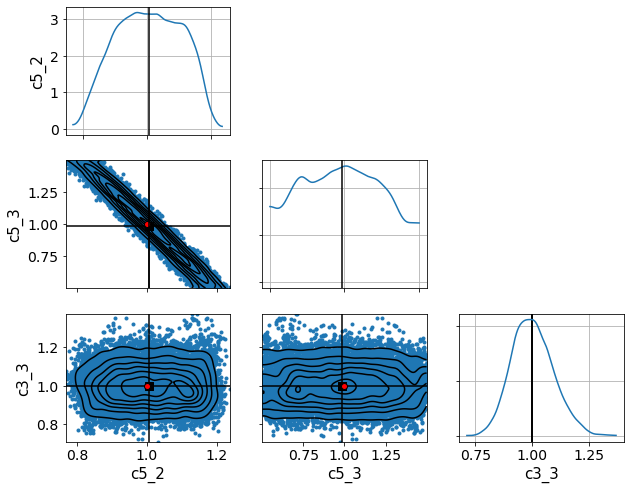

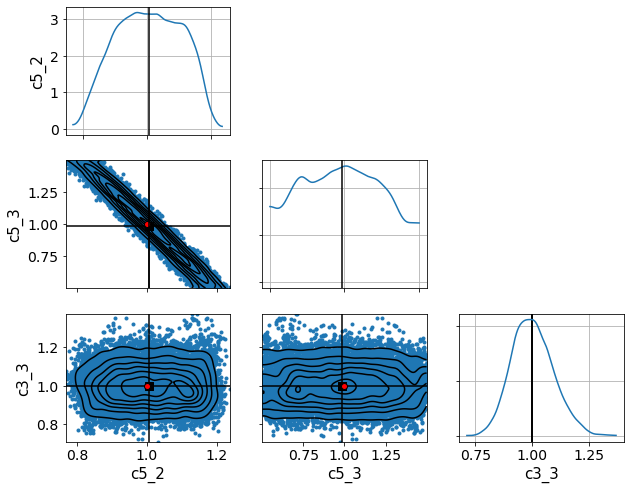

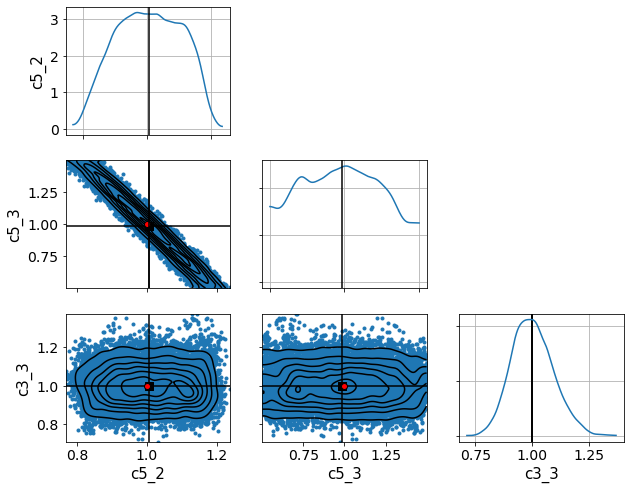

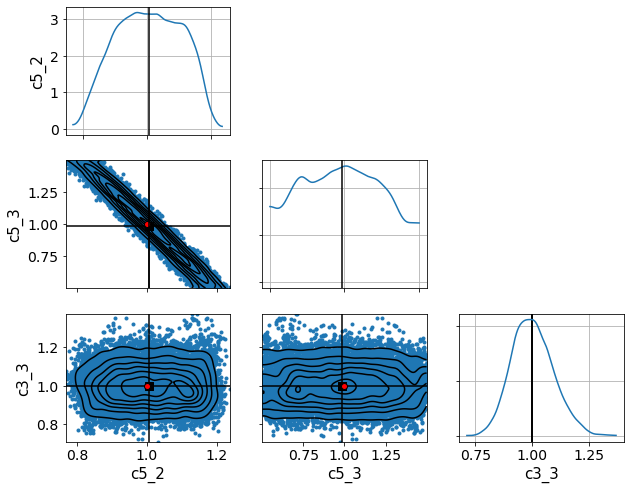

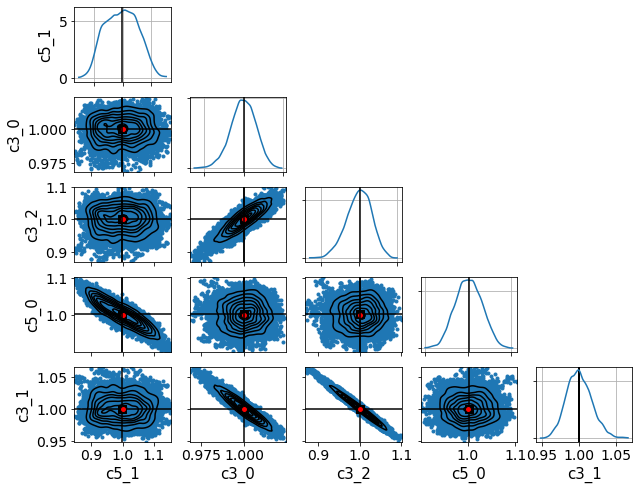

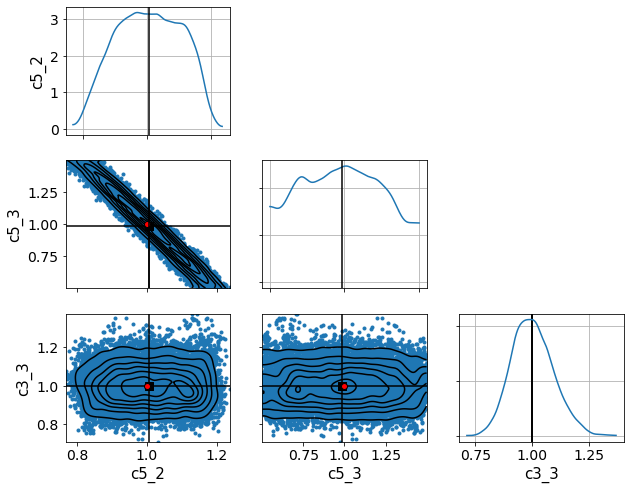

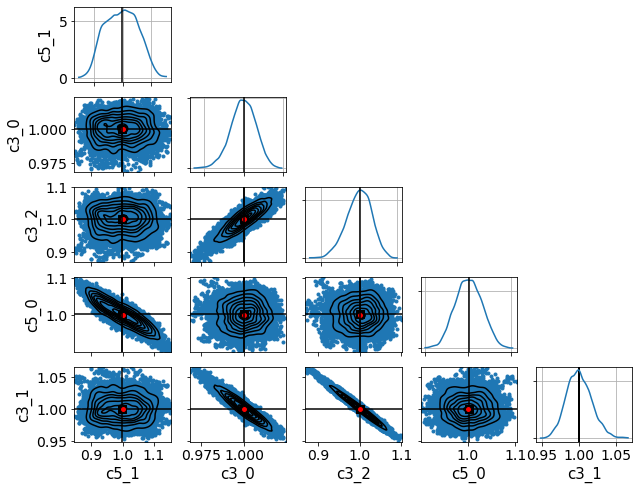

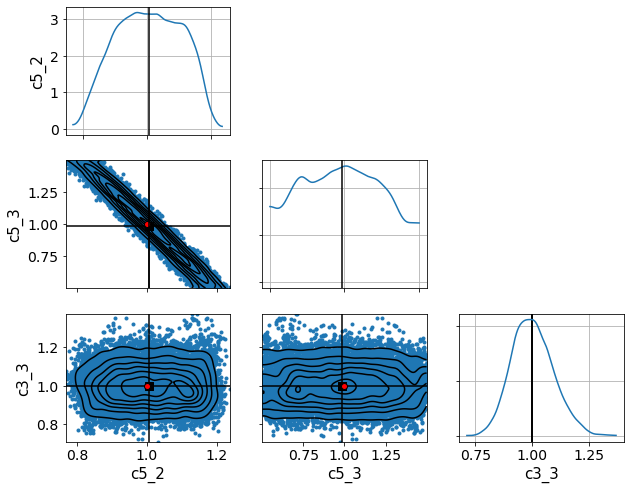

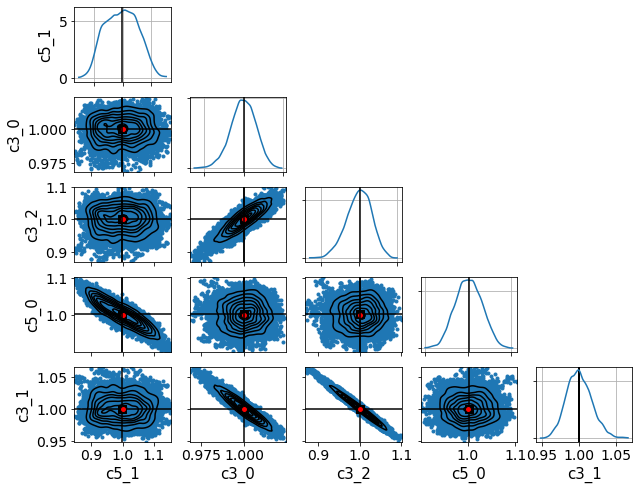

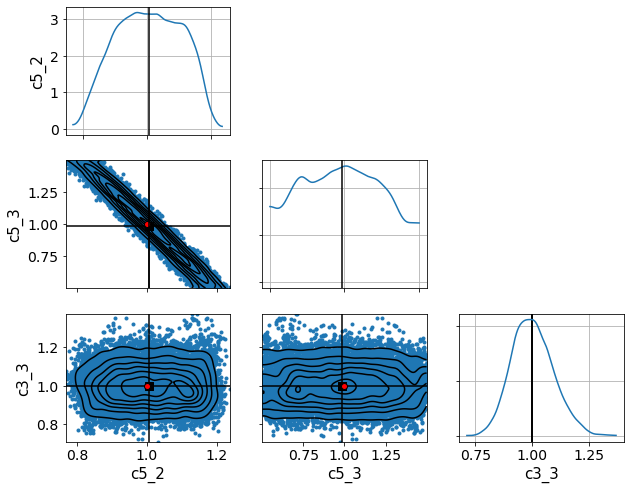

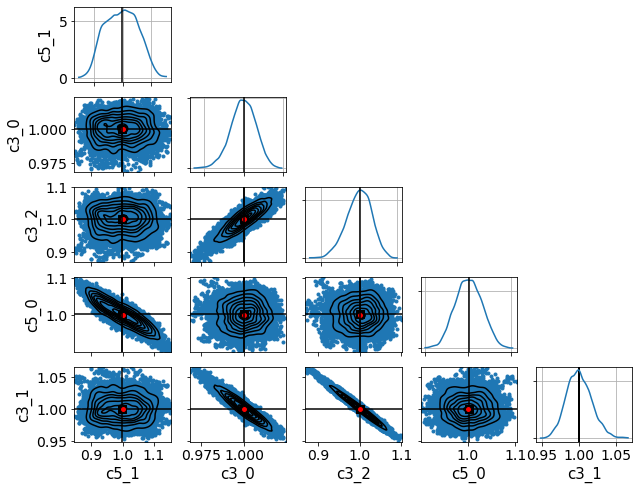

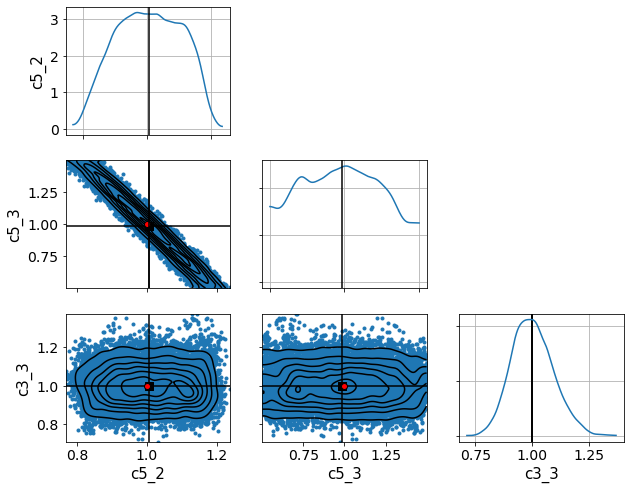

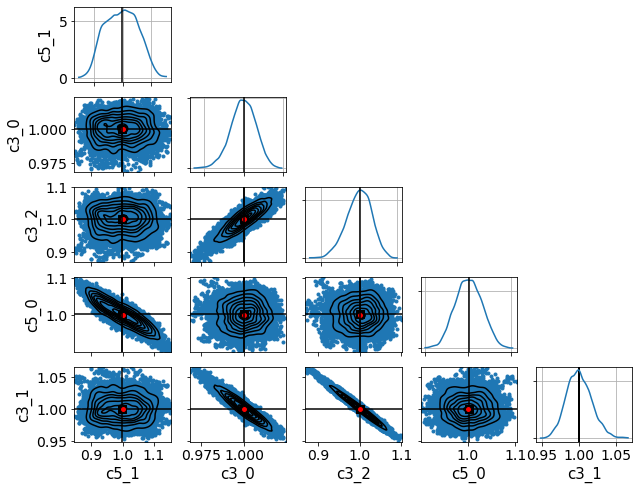

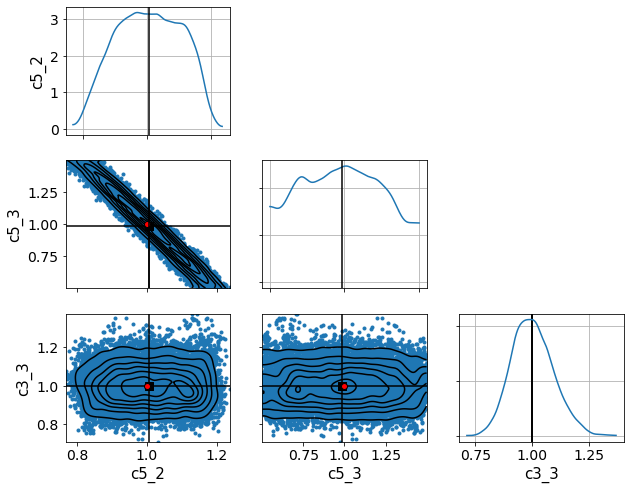

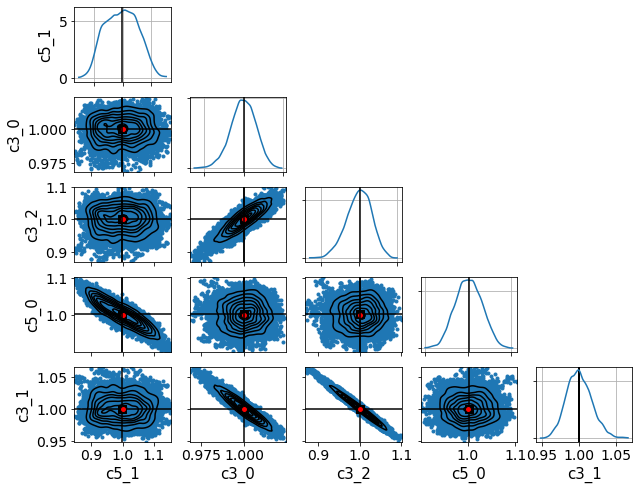

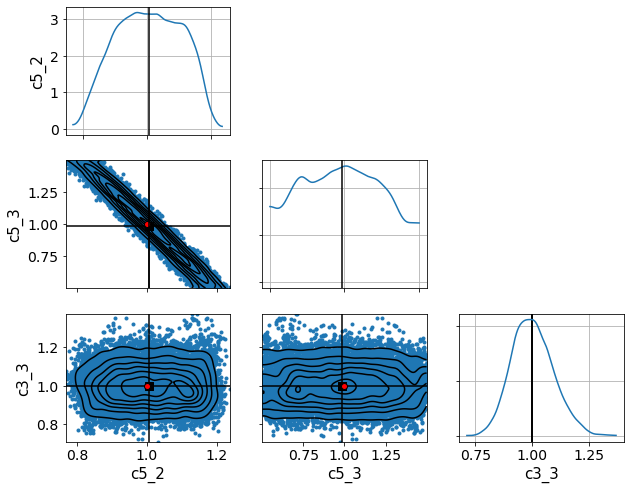

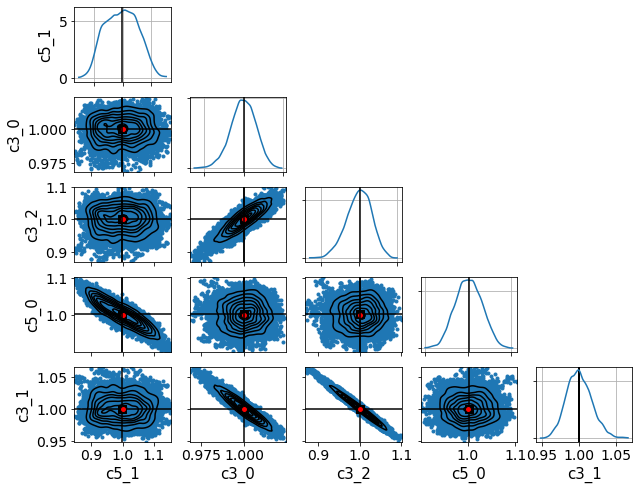

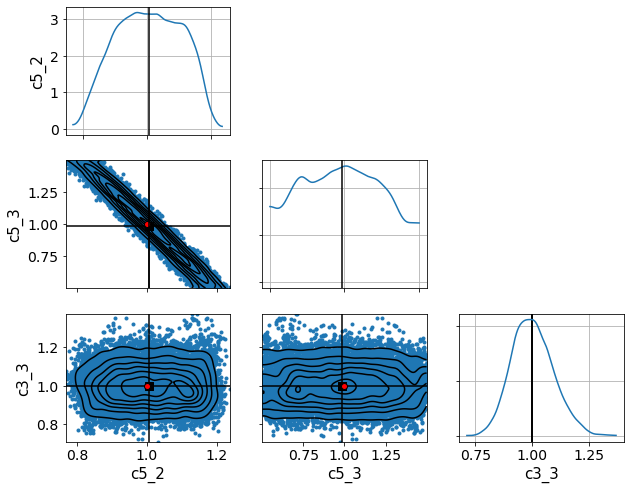

In [3]:
%run dpy_jax/run_reduced_problem_model.py --warmup 10 --chain_num 5 --maxiter 10

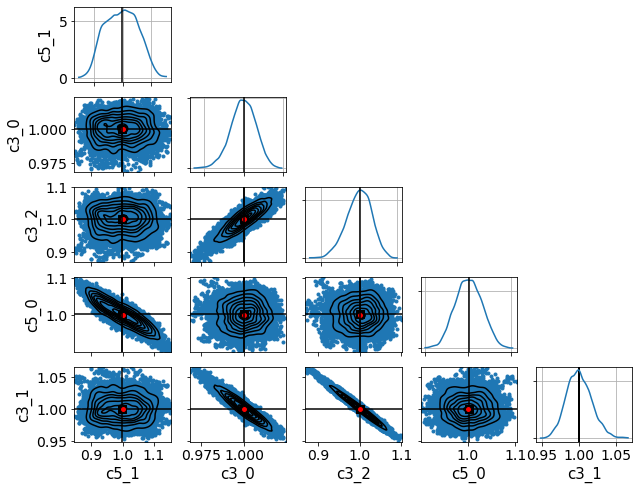

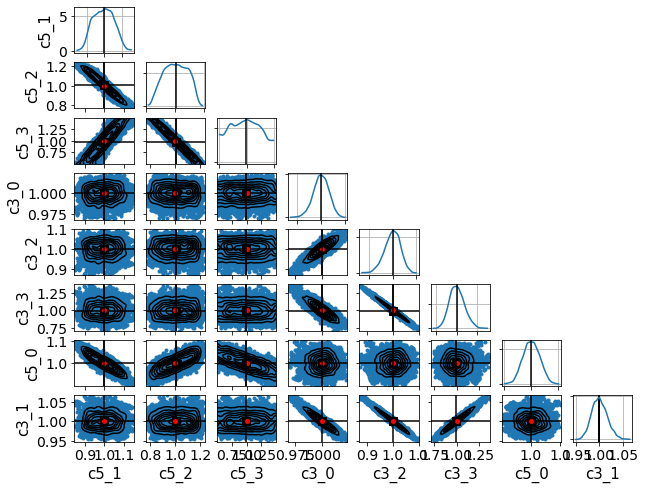

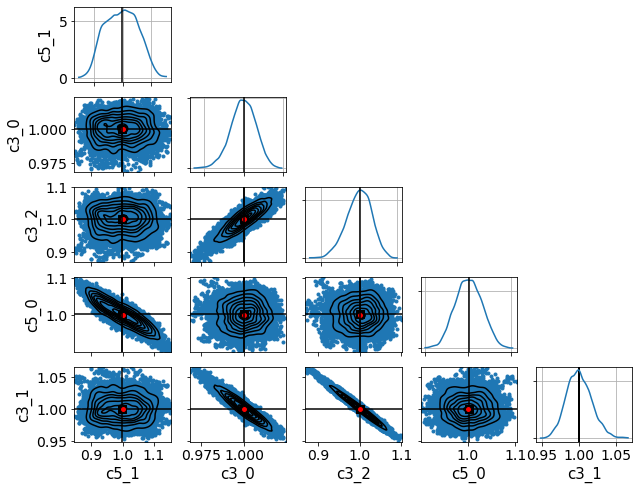

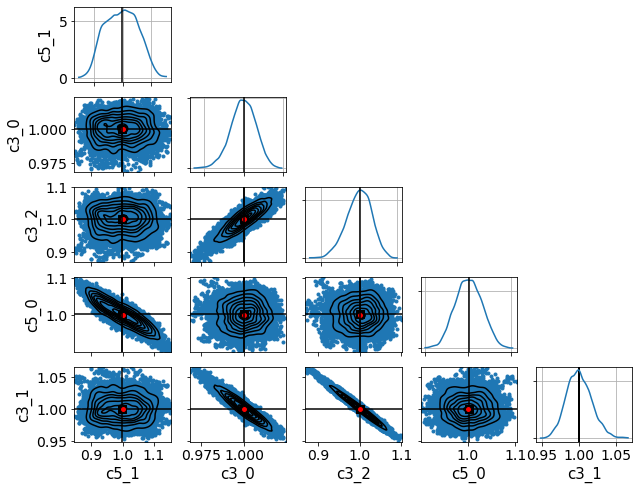

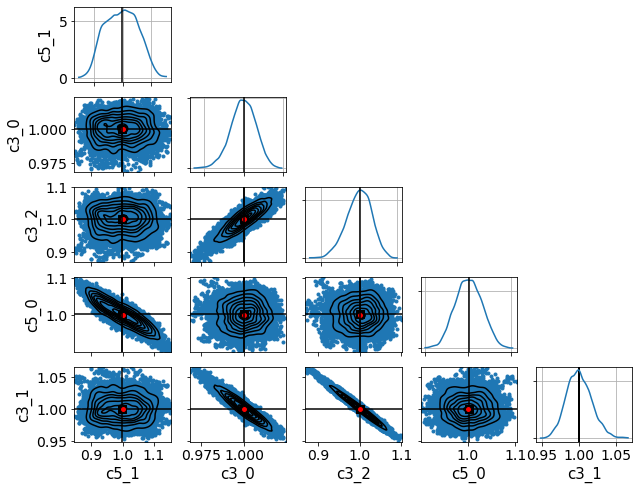

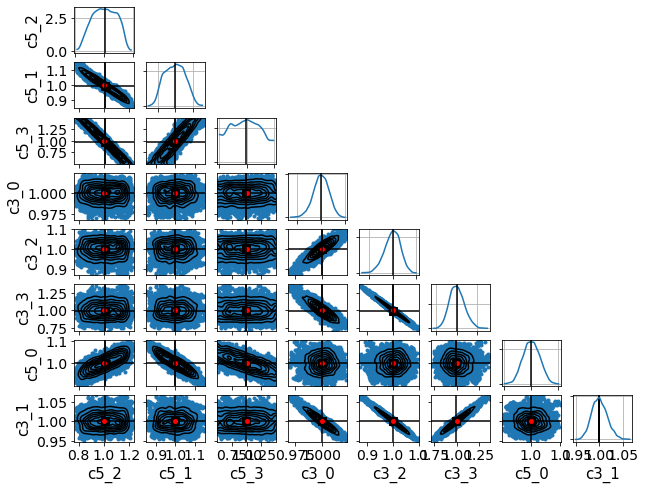

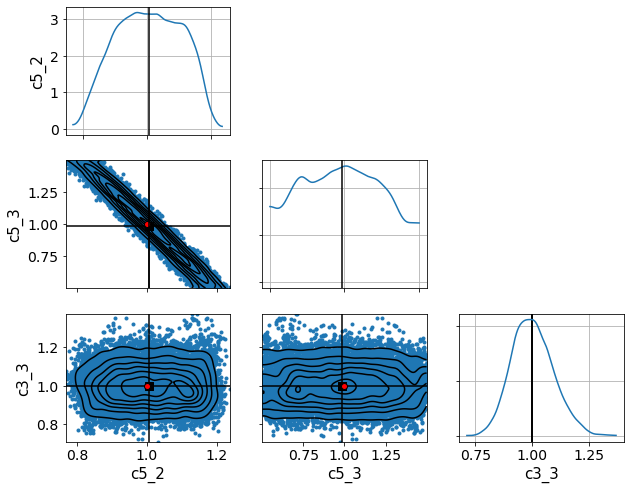

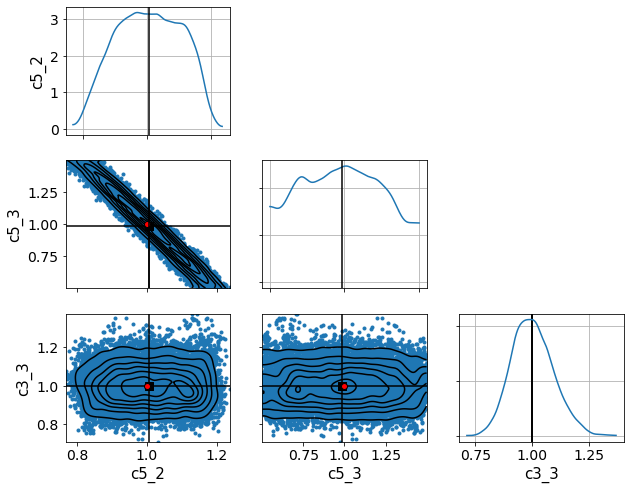

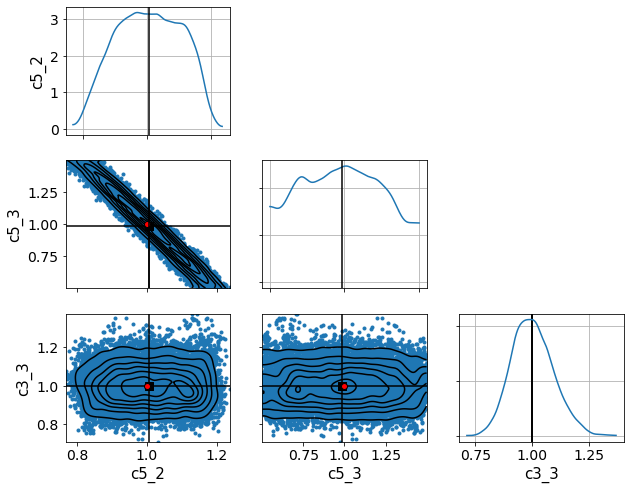

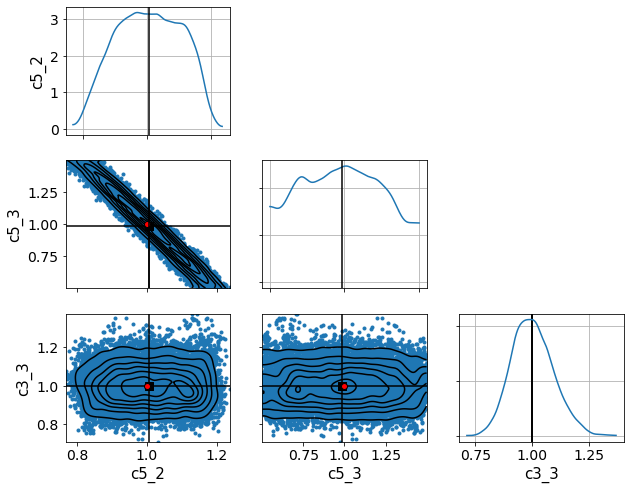

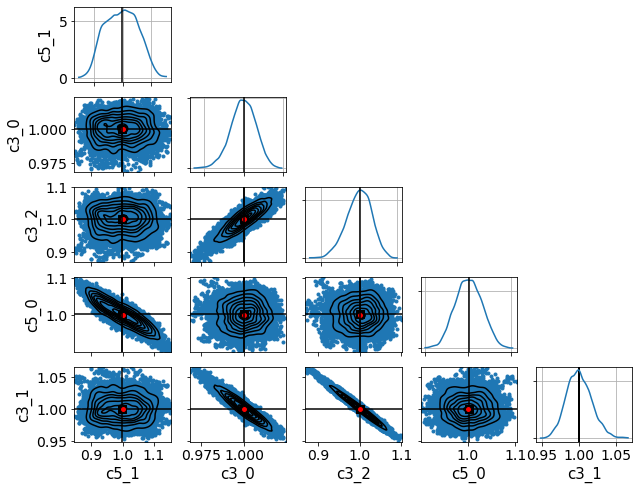

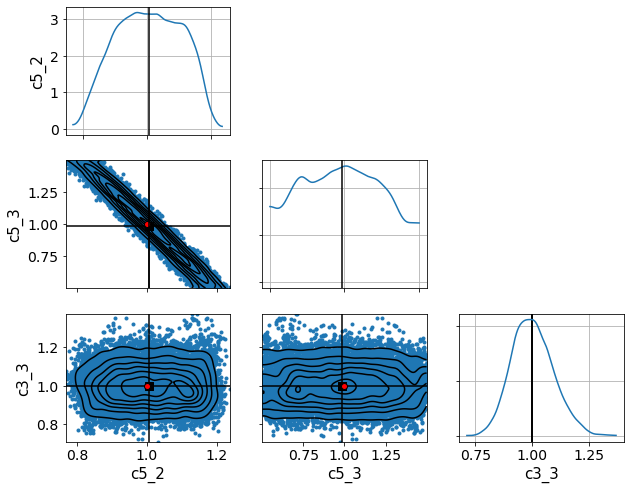

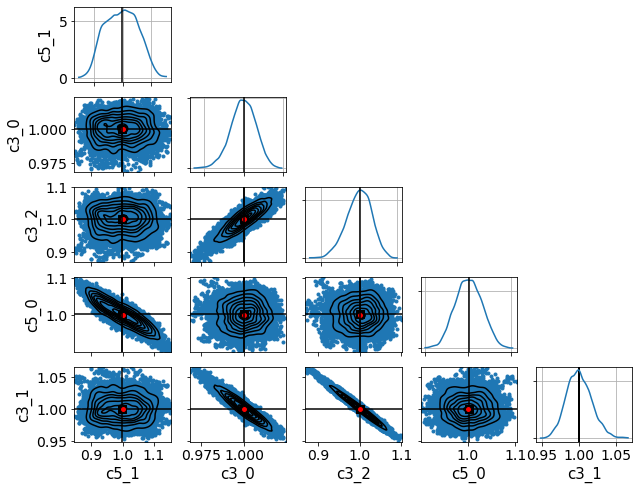

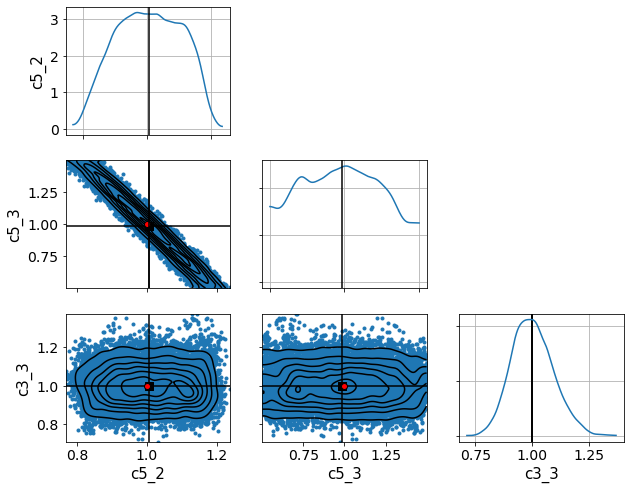

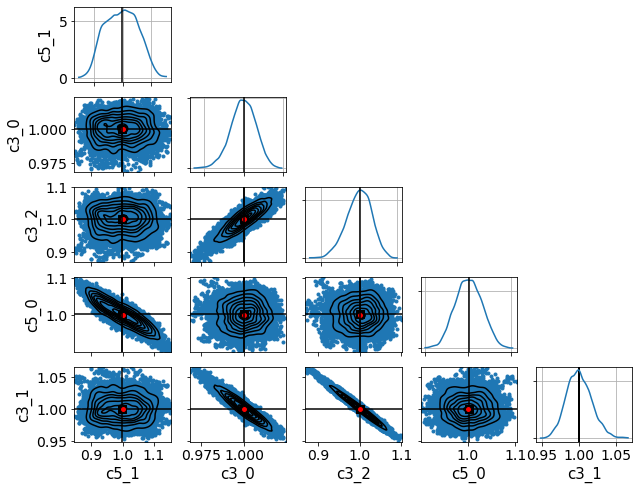

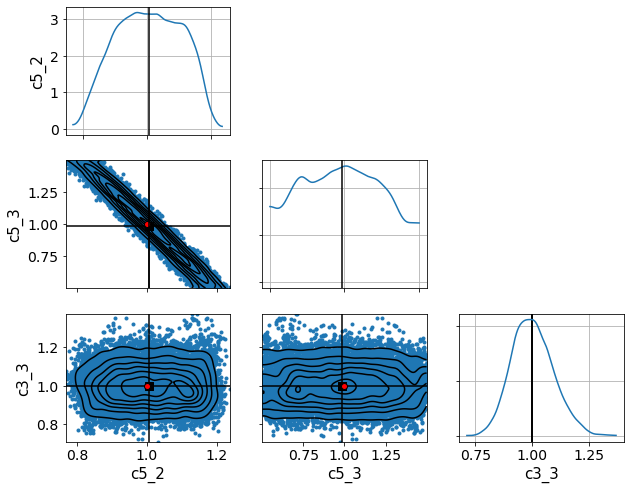

In [8]:
plot_corner_split(plot_samples, params_per_plot=4)